In [1]:
import glob
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from adjustText import adjust_text

metrics_to_use = ["student_model_name", "T", "bs", "loss_ratio", 
                  "conditional", "curriculum", "cosine_decay",
                  "inference_speed", "student_memory", "student_num_params", 
                  "train_loss", "val_loss", "train_acc", "val_acc"]

In [2]:
# Get all JSONs from results folder
json_files = glob.glob('./results/*.json')
json_file_names = [os.path.basename(file) for file in json_files]

# print(json_file_names)

In [3]:
json_data = []

# Read result files separately for teacher and students
for file in json_files:
    with open(file, 'r') as json_file:
        if "vgg16" not in file:
            data = json.load(json_file)
            json_data.append(data)
        else:
            teacher_data = json.load(json_file)


In [4]:
# teacher_data

In [5]:
teacher_data["student_model_name"] = "teacher_model"
# last loss/acc
teacher_data["train_loss"] = teacher_data["train_loss"][-1]
teacher_data["train_acc"] = teacher_data["train_acc"][-1]
# min inference speed
teacher_data["inference_speed"] = min(teacher_data["inference_speed"])
teacher_data["val_loss"] = teacher_data["val_loss"][-1]
teacher_data["val_acc"] = teacher_data["val_acc"][-1]
teacher_data = [{key: teacher_data.get(key, False) for key in metrics_to_use}]
# teacher_data

In [6]:
# json_data

In [7]:
# Return only key:values that are used for plotting
json_data = [{key: report.get(key, False) for key in metrics_to_use} for report in json_data]
# json_data

In [8]:
# Aggregate data
# last loss/acc and min inference speed
for report in json_data:
    for key, value in report.items():
        # if isinstance(value, list):
        if key in ['train_loss', 'train_acc', 'val_loss', 'val_acc']:
            new_value = value[-1]
            report[key] = new_value
        if key == 'inference_speed':
            new_value = min(value)
            report[key] = new_value

# json_data

In [9]:
# Join teacher result with student results
full_json = (teacher_data + json_data)

In [10]:
df = pd.DataFrame(full_json)
# df.insert(column="model_name", loc=1, value=f"{df['student_model_name']}_T={df['T']}_lossr={df['loss_ratio']}")
df.insert(loc=1, column='full_model_name', 
          value=df['student_model_name'] + 
                '_T=' + df['T'].astype(str) + 
                '_lossr=' + df['loss_ratio'].astype(str) + 
                '_cond=' + df['conditional'].astype(str) +
                '_curr=' + df['curriculum'].astype(str) +
                '_cosd=' + df['cosine_decay'].astype(str))
df.insert(loc=2, column='hyperparameters', 
          value=np.where(df['curriculum'], 
                           # Add a string to numpy array of strings element-wise
                           np.core.defchararray.add(" Curr + ", np.where(df['cosine_decay'], "Cos decay", "Lin decay")),
                           ' T=' + df['T'].astype(str)) +
                  np.where(df['conditional'], 
                           " Cond", 
                           ' lossr=' + df['loss_ratio'].astype(str)))
df.insert(loc=2, column='model_name', 
          value=df['student_model_name'] + df['hyperparameters'])
df['student_num_params'] = df['student_num_params'] / 1e6
df["relative_val_loss"] = df["val_loss"] / teacher_data[0]["val_loss"]
df["relative_val_acc"] = df["val_acc"] / teacher_data[0]["val_acc"]
df["inference_speedup"] = teacher_data[0]["inference_speed"] / df["inference_speed"]
# Remove hyperparameters for teacher model
df.loc[df['student_model_name'] == "teacher_model", ["full_model_name", "model_name", "hyperparameters"]] = "Teacher model"

print(df.shape)
# Filter batch size 256
df = df[(df['model_name'] == 'teacher_model') | (df['bs'] == 256)].reset_index(drop=True)
print(df)
print(df.shape)

df_melted_model = pd.melt(df, id_vars=["student_model_name", "full_model_name", "model_name", "hyperparameters"], var_name="metric", value_name="value")
df_melted_model['value'] = df_melted_model['value'].astype(float)

(27, 20)
    student_model_name                                    full_model_name  \
0        teacher_model                                      Teacher model   
1             ghostnet  ghostnet_T=1_lossr=0.0_cond=False_curr=False_c...   
2             ghostnet  ghostnet_T=2_lossr=0.5_cond=False_curr=False_c...   
3             ghostnet  ghostnet_T=4_lossr=0.5_cond=True_curr=False_co...   
4             ghostnet  ghostnet_T=4_lossr=0.5_cond=False_curr=False_c...   
5             ghostnet  ghostnet_T=6_lossr=0.5_cond=False_curr=False_c...   
6             ghostnet  ghostnet_T=4_lossr=0.5_cond=False_curr=True_co...   
7             ghostnet  ghostnet_T=4_lossr=0.5_cond=False_curr=True_co...   
8   mobilenet-V3-large  mobilenet-V3-large_T=1_lossr=0.0_cond=False_cu...   
9   mobilenet-V3-large  mobilenet-V3-large_T=4_lossr=0.5_cond=False_cu...   
10  mobilenet-V3-large  mobilenet-V3-large_T=6_lossr=0.5_cond=False_cu...   
11  mobilenet-V3-large  mobilenet-V3-large_T=4_lossr=0.5_cond=True_

In [11]:
def plot_metrics(df, metric, model_group="All", plot=False):
    if model_group.lower() == "best":
        name_column = "model_name"
        legend_name = "Model name"
    else:
        name_column = "hyperparameters"
        legend_name = "Hyperparameters"
    plt.figure(figsize=(10, 6))
    sns.barplot(x='metric', y='value', hue=name_column, data=df)
    plt.title(f'{model_group.capitalize()} models - {metric}')
    plt.xlabel('')
    plt.ylabel(metric)
    plt.legend(title=legend_name)
    plt.savefig(f'images/{metric.lower()}_{model_group}.png')
    if plot:
        plt.show()
    else:
        plt.close()

In [12]:
def get_best_models(df, metric="Val loss"):
    # Find index of best metric for each student_model_name
    grpd_values = df[df['metric'] == metric].groupby(['student_model_name'])['value']
    # Min if loss, max if accuracy
    best_idxs = grpd_values.idxmin() if "loss" in metric else grpd_values.idxmax()
    
    # Get corresponding student_model_name and hyperparameters from original DataFrame
    best_models_info = df.loc[best_idxs, ['student_model_name', 'hyperparameters']]
    
    # Select all rows from original DataFrame that match student_model_name and hyperparameters of best models
    return pd.merge(df, best_models_info, on=['student_model_name', 'hyperparameters'])


## Plot losses

In [13]:
df_melted_losses = df_melted_model[df_melted_model["metric"].isin(['train_loss', 'val_loss'])].copy()
df_melted_losses['metric'] = [s.replace('_', ' ').capitalize() for s in df_melted_losses['metric']]


In [14]:
plot_metrics(df=df_melted_losses[df_melted_losses["student_model_name"].isin(["teacher_model", "ghostnet"])], 
             metric="Loss", model_group="ghostnet", plot=False)
plot_metrics(df=df_melted_losses[df_melted_losses["student_model_name"].isin(["teacher_model", "mobilenet-V3-large"])], 
             metric="Loss", model_group="mobilenet-V3-large", plot=False)
plot_metrics(df=df_melted_losses[df_melted_losses["student_model_name"].isin(["teacher_model", "mobilenet-V3-small"])], 
             metric="Loss", model_group="mobilenet-V3-small", plot=False)
plot_metrics(df=df_melted_losses[df_melted_losses["student_model_name"].isin(["teacher_model", "shufflenet"])], 
             metric="Loss", model_group="shufflenet", plot=False)


In [15]:
best_losses_df = get_best_models(df=df_melted_losses, metric="Val loss")
plot_metrics(df=best_losses_df, metric="Loss", model_group="Best", plot=False)

## Plot accuracies

In [16]:
# df_melted_accs = df_melted_model[df_melted_model["metric"].isin(['train_acc', 'val_acc', 'relative_val_acc'])].copy()
df_melted_accs = df_melted_model[df_melted_model["metric"].isin(['train_acc', 'val_acc'])].copy()
df_melted_accs['metric'] = [s.replace('_', ' ').capitalize() for s in df_melted_accs['metric']]

In [17]:
plot_metrics(df=df_melted_accs[df_melted_accs["student_model_name"].isin(["teacher_model", "ghostnet"])], 
             metric="Accuracy", model_group="ghostnet", plot=False)
plot_metrics(df=df_melted_accs[df_melted_accs["student_model_name"].isin(["teacher_model", "mobilenet-V3-large"])], 
             metric="Accuracy", model_group="mobilenet-V3-large", plot=False)
plot_metrics(df=df_melted_accs[df_melted_accs["student_model_name"].isin(["teacher_model", "mobilenet-V3-small"])], 
             metric="Accuracy", model_group="mobilenet-V3-small", plot=False)
plot_metrics(df=df_melted_accs[df_melted_accs["student_model_name"].isin(["teacher_model", "shufflenet"])], 
             metric="Accuracy", model_group="shufflenet", plot=False)


In [18]:
best_accs_df = get_best_models(df=df_melted_accs, metric="Val acc")
plot_metrics(df=best_accs_df, metric="Accuracy", model_group="Best", plot=False)

## Scatter plots for model comparison

In [19]:
def is_float(s):
    """
    Helper function to check if string can be converted to float.
    """
    try:
        float(s)
        return True
    except ValueError:
        return False

def scatterplot_compare(df, model_group="All", plot=False, model_name_pos="lower right", model_size_pos="upper left"):
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    

    if model_group.lower() == "best":
        name_column = "model_name"
        legend_name = "Model name"
    else:
        name_column = "hyperparameters"
        legend_name = "Hyperparameters"

    # Create a color palette
    palette = sns.color_palette("hls", df[name_column].nunique())
    
    scatter = sns.scatterplot(data=df, x='inference_speedup', y='relative_val_acc', 
                              size='student_memory', sizes=(50, 200), 
                              hue=name_column, palette=palette)

    plt.xlim(left=1)
    plt.ylim(top=1)

    # Get labels of double legend
    handles, labels = scatter.get_legend_handles_labels()
    # Round model sizes and add MB, leave model names as is
    labels = [f'{round(float(label), 1)} MB' if is_float(label) else label for label in labels]
    
    # Create two legends: one for size and one for model name (hue)
    size_legend = plt.legend(handles[-len(df['student_memory'].unique()):], 
                             labels[-len(df['student_memory'].unique()):], 
                             title='Model size (MB)', loc=model_size_pos)
    color_legend = plt.legend(handles[1:len(df[name_column].unique())+1], 
                              labels[1:len(df[name_column].unique())+1], 
                              title=legend_name, loc=model_name_pos)
    
    # Add the other legend
    plt.gca().add_artist(size_legend)

    plt.title(f'{model_group.capitalize()} models')
    plt.xlabel('Inference Speedup')
    plt.ylabel('Relative Validation Accuracy')
    plt.savefig(f'images/fat_plot_{model_group}.png')
    if plot:
        plt.show()
    else:
         plt.close()


In [20]:
# for model_name in df["student_model_name"].unique()[1:]:
#     print(model_name)

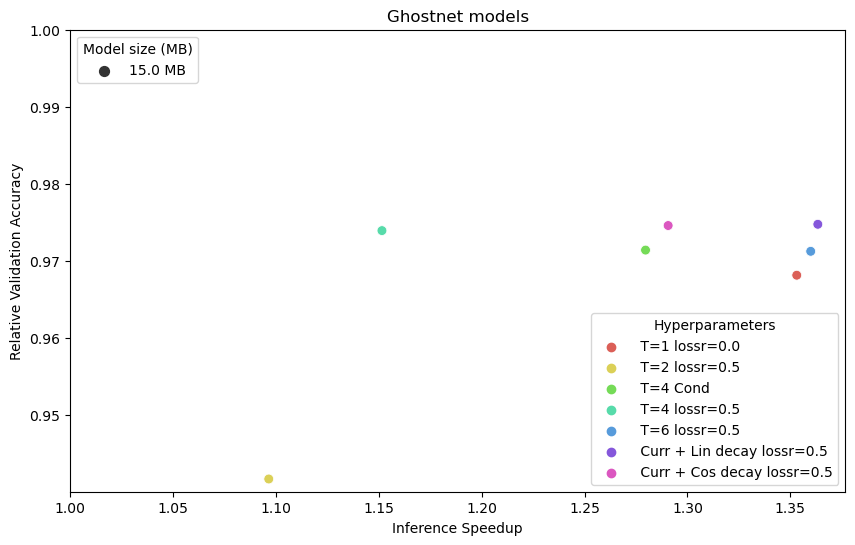

In [21]:
scatterplot_compare(df=df[df["student_model_name"].isin(["ghostnet"])], 
                    model_group="ghostnet", plot=True)

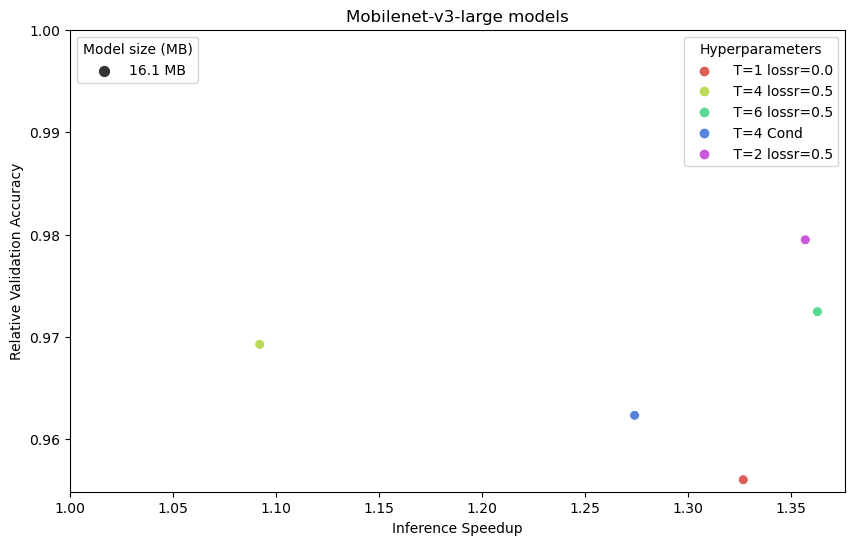

In [22]:
scatterplot_compare(df=df[df["student_model_name"].isin(["mobilenet-V3-large"])], 
                    model_group="mobilenet-V3-large", plot=True,
                    model_name_pos="upper right")

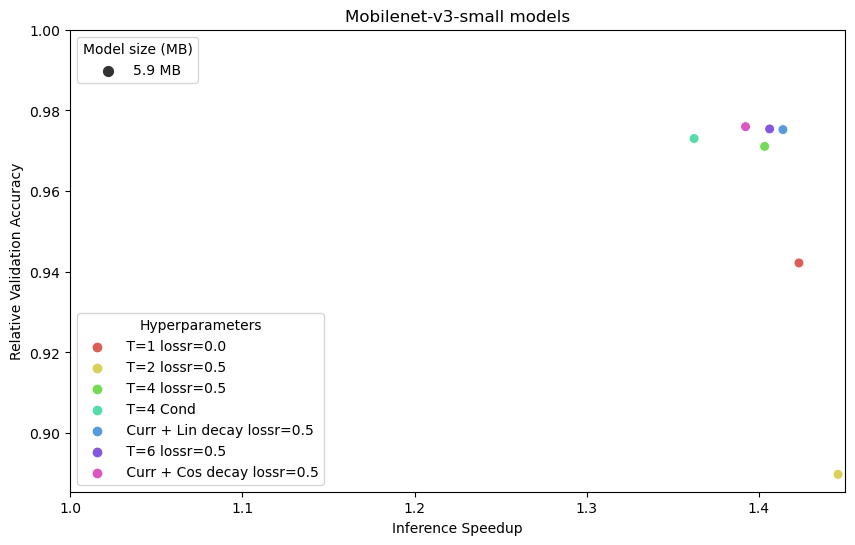

In [23]:
scatterplot_compare(df=df[df["student_model_name"].isin(["mobilenet-V3-small"])], 
                    model_group="mobilenet-V3-small", plot=True,
                    model_name_pos="lower left")

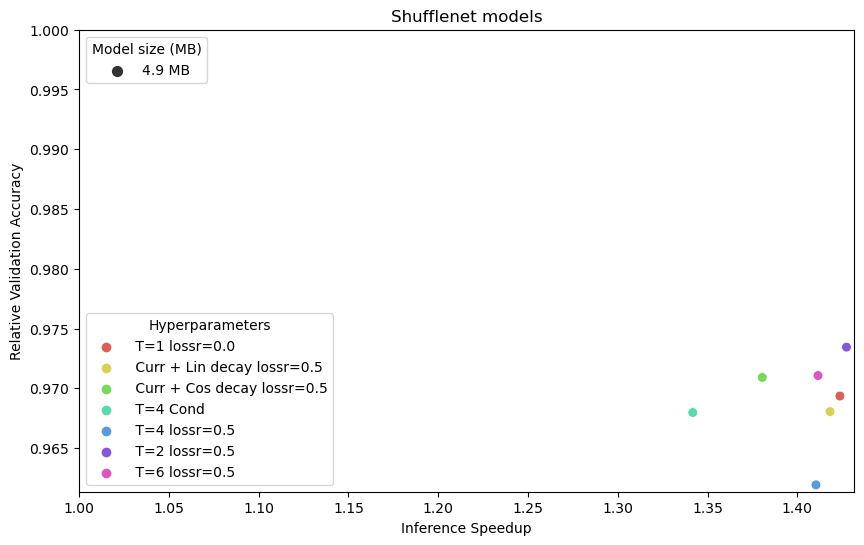

In [24]:
scatterplot_compare(df=df[df["student_model_name"].isin(["shufflenet"])], 
                    model_group="shufflenet", plot=True,
                    model_name_pos="lower left")

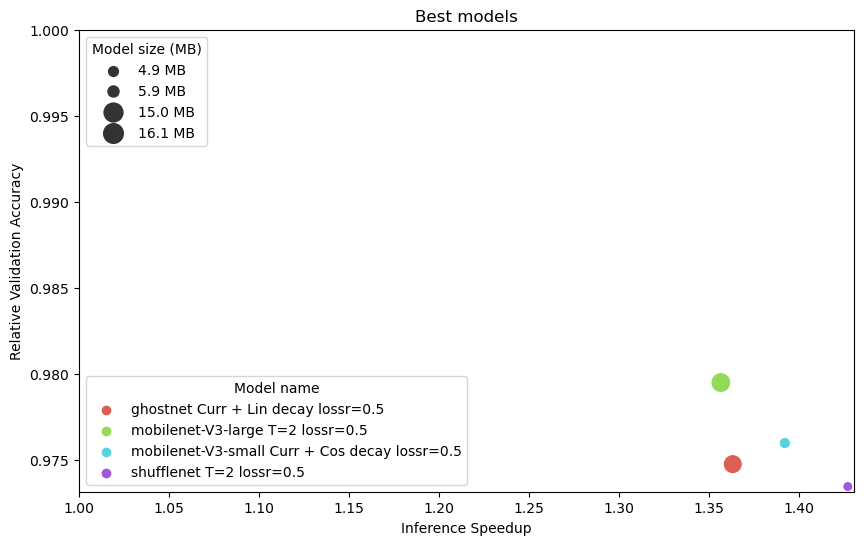

In [25]:
# Save results for best model (based on val acc) of each architecture
best_df = df.loc[df.groupby('student_model_name')['val_acc'].idxmax()].reset_index(drop=True)
best_df = best_df[best_df["student_model_name"] != "teacher_model"] # exclude teacher model
scatterplot_compare(best_df, model_group="best", plot=True,
                    model_name_pos="lower left")